In [4]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
from sklearn.metrics.pairwise import rbf_kernel, laplacian_kernel

from scipy.integrate import quad
from scipy.interpolate import interp1d

from SyntheticDataModule import *
from estimators import *
from utils import *

In [ ]:
df_combined

RCT size: 1500, OS size: 4500, time elapsed: 23.31


S   d     n  True mean Y0  Impute mean Y0  Drop mean Y0  \
0  0  10  1500      2.291883        2.270901      2.270901   
1  1  10  4500      2.226613        2.037127      2.068668   

   Oracle-IPCW mean Y0  True mean Y1  Impute mean Y1  Drop mean Y1  \
0             2.210382      6.248333        6.281755      6.272832   
1             2.329834      5.313583        4.233770      4.403398   

   Oracle-IPCW mean Y1  True ATE  Impute ATE  Drop ATE  Oracle-IPCW ATE  
0             6.451207   3.95645    4.010854  4.001931         4.240825  
1             5.007418   3.08697    2.196643  2.334730         2.677584

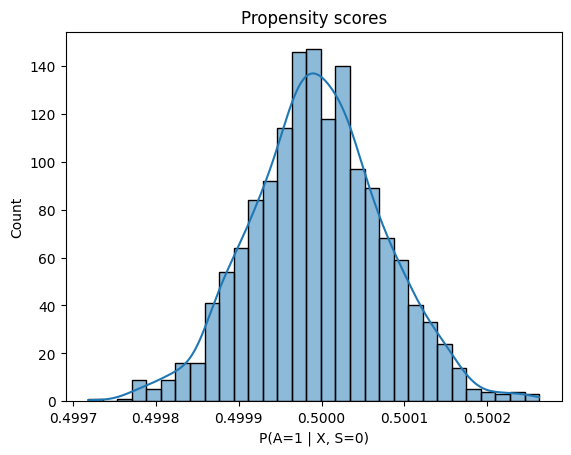

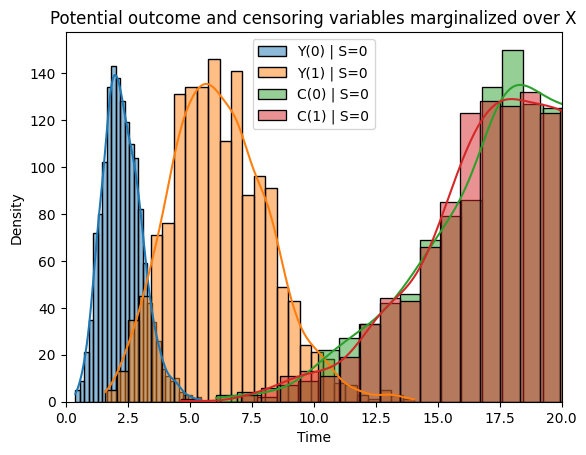

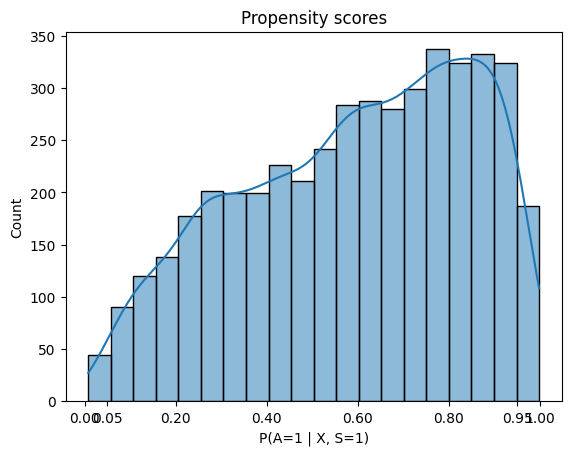

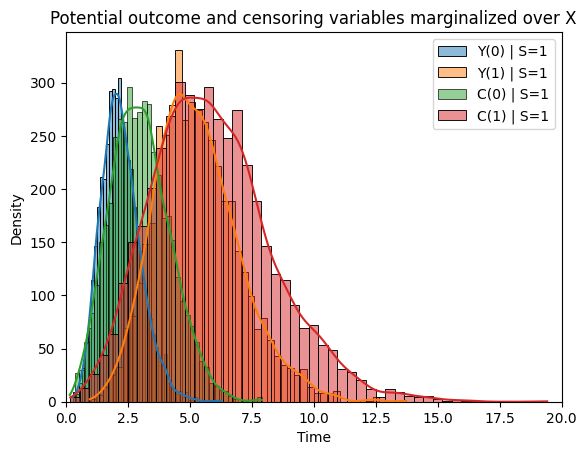

RCT size: 1500, OS size: 3000, time elapsed: 17.96
RCT size: 1500, OS size: 3000, time elapsed: 18.03
RCT size: 1500, OS size: 3000, time elapsed: 18.06
RCT size: 1500, OS size: 3000, time elapsed: 18.53
RCT size: 1500, OS size: 3000, time elapsed: 17.96
RCT size: 1500, OS size: 3000, time elapsed: 17.43
RCT size: 1500, OS size: 3000, time elapsed: 17.84
RCT size: 1500, OS size: 3000, time elapsed: 17.51
RCT size: 1500, OS size: 3000, time elapsed: 17.20
RCT size: 1500, OS size: 3000, time elapsed: 17.83
RCT size: 1500, OS size: 3000, time elapsed: 18.56
RCT size: 1500, OS size: 3000, time elapsed: 17.58
RCT size: 1500, OS size: 3000, time elapsed: 16.55
RCT size: 1500, OS size: 3000, time elapsed: 17.57
RCT size: 1500, OS size: 3000, time elapsed: 18.01
RCT size: 1500, OS size: 3000, time elapsed: 17.70
RCT size: 1500, OS size: 3000, time elapsed: 17.23
RCT size: 1500, OS size: 3000, time elapsed: 16.29
RCT size: 1500, OS size: 3000, time elapsed: 11.66
RCT size: 1500, OS size: 3000, 

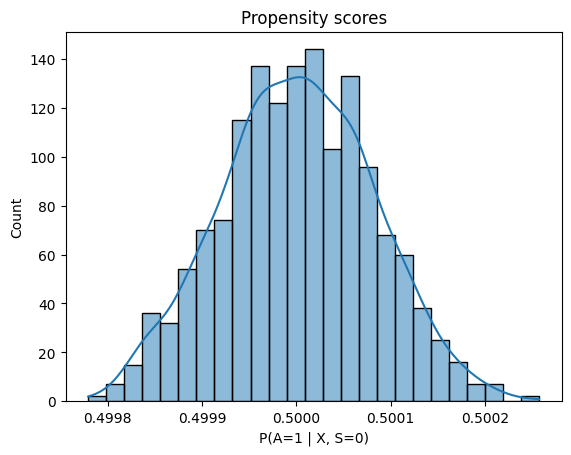

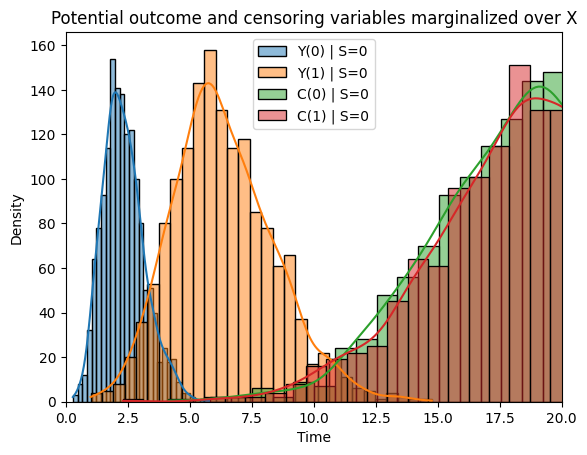

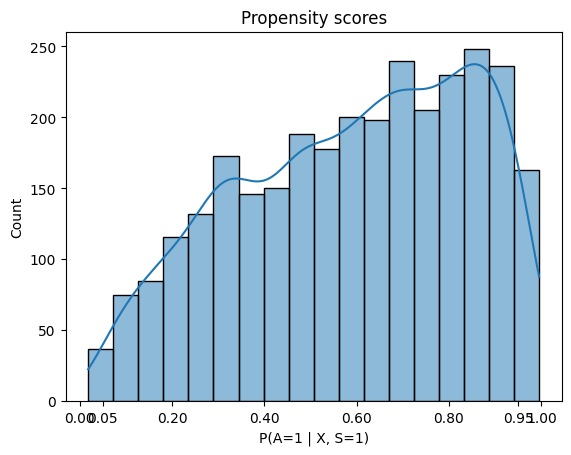

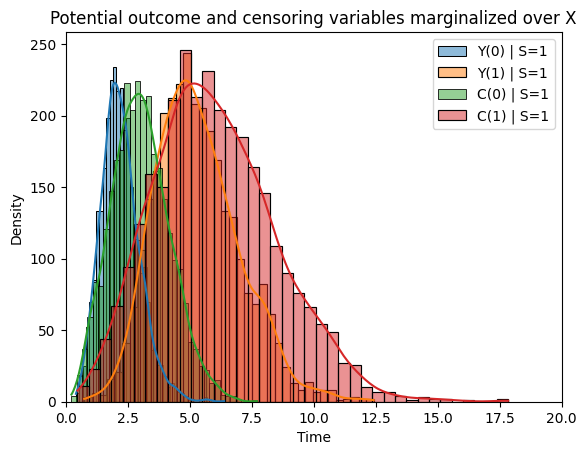

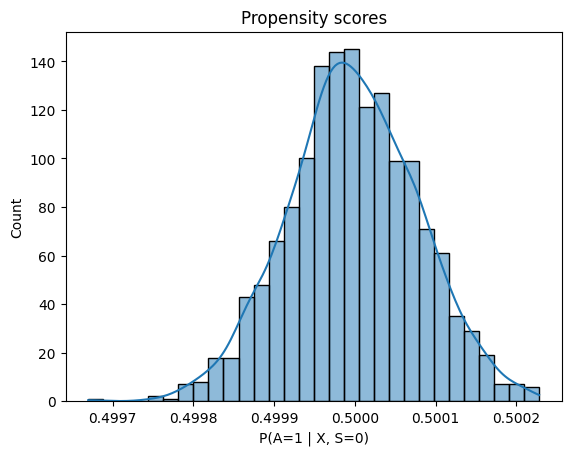

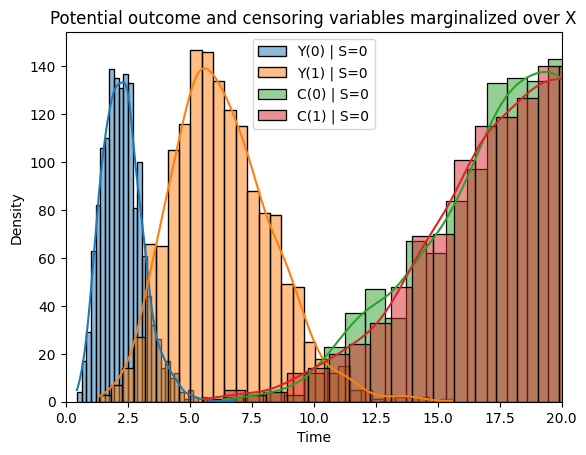

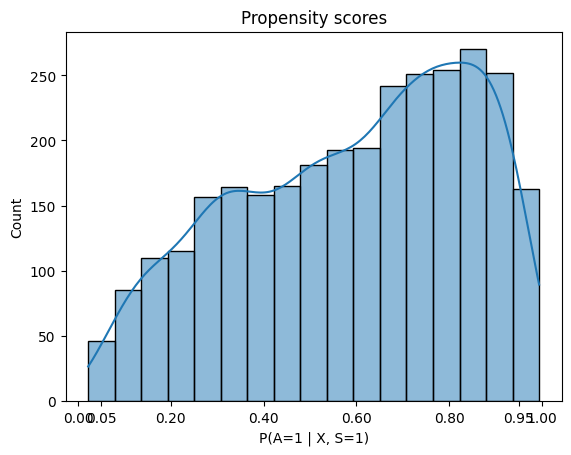

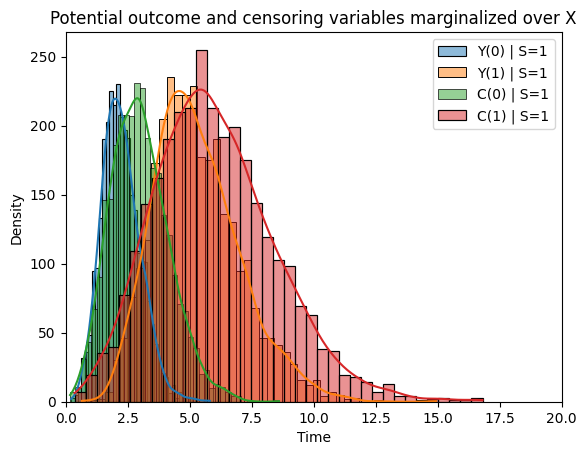

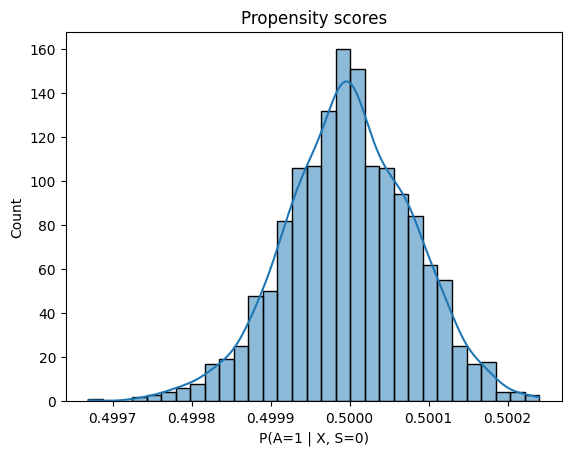

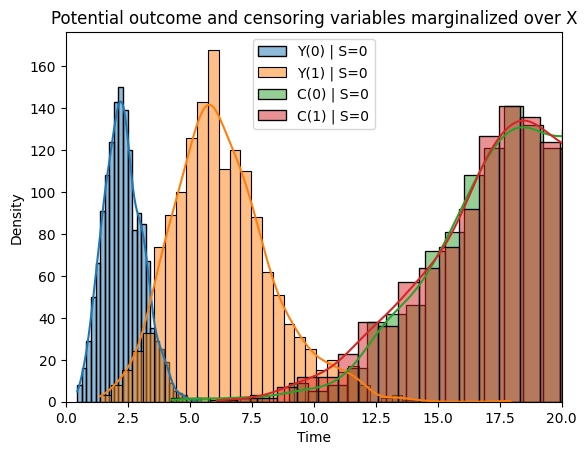

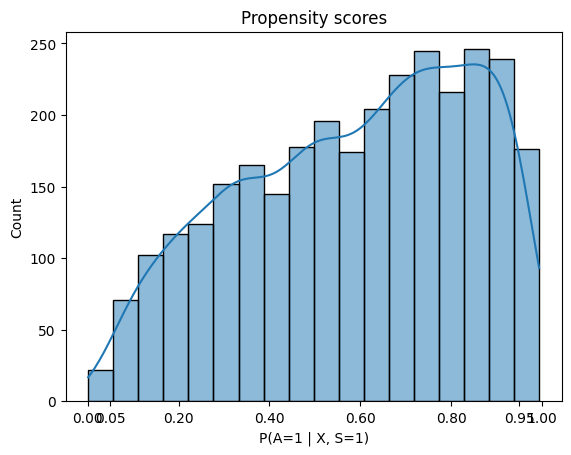

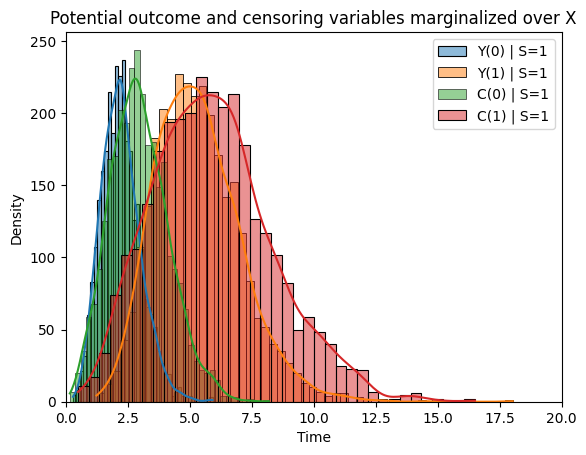

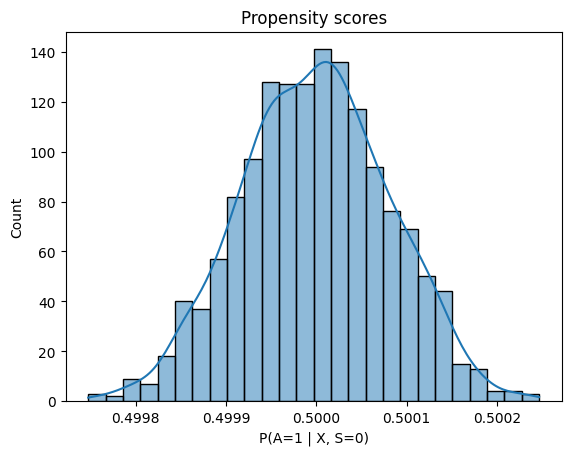

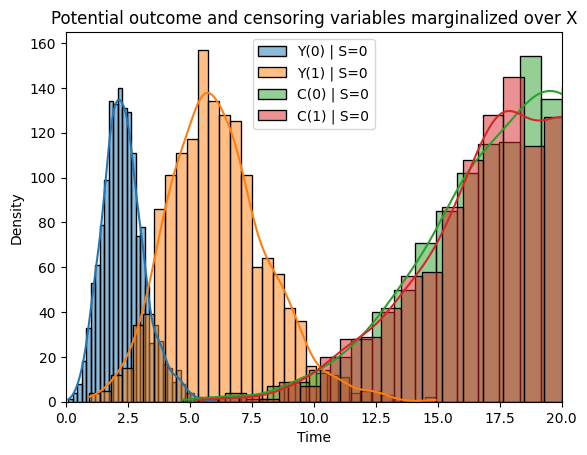

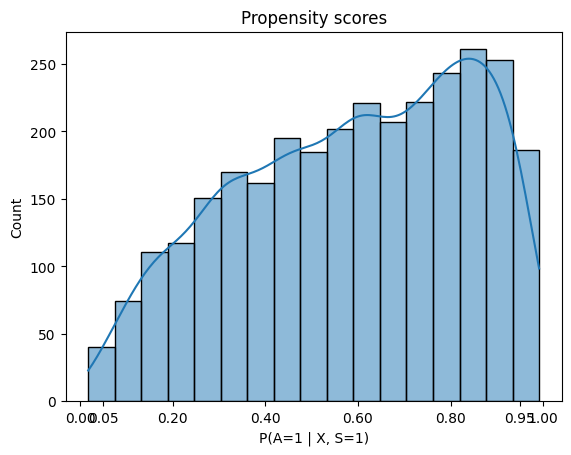

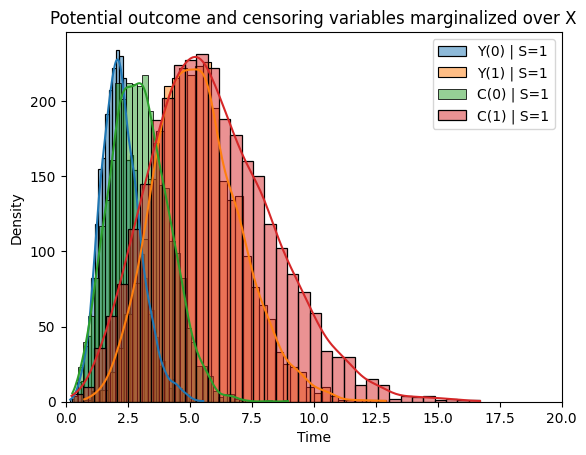

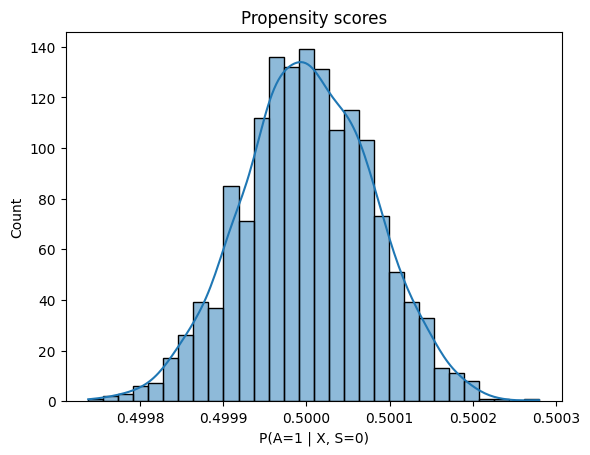

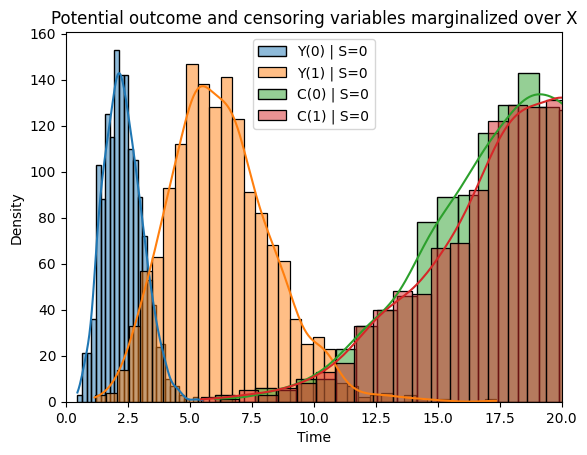

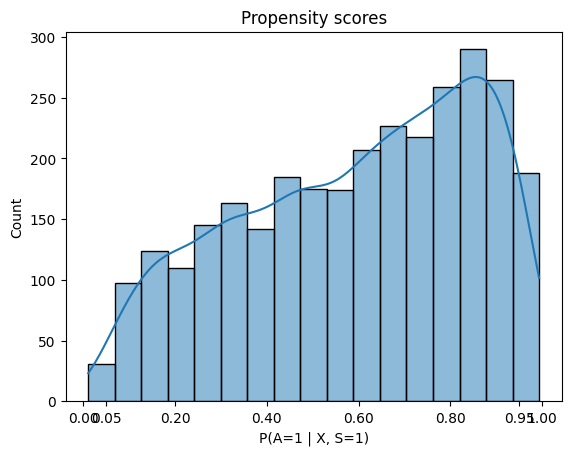

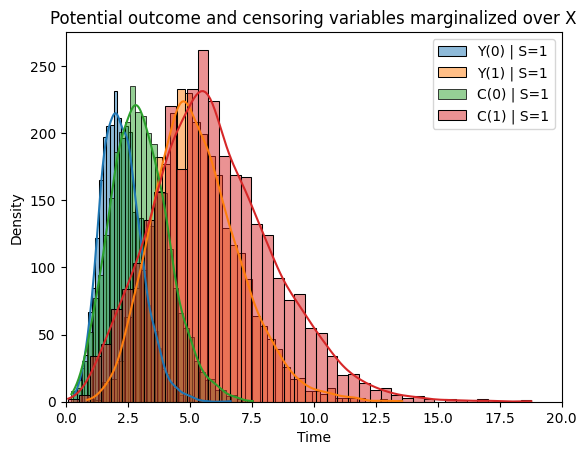

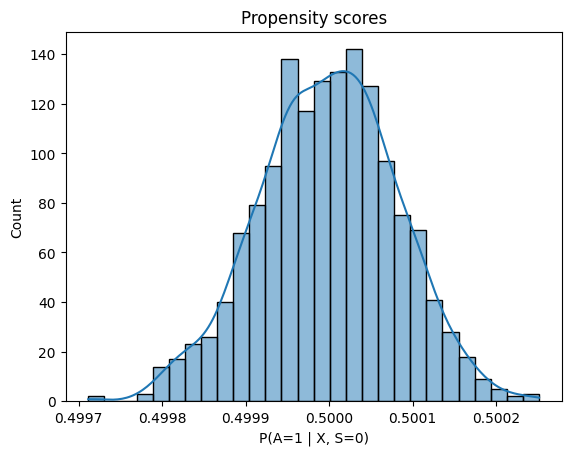

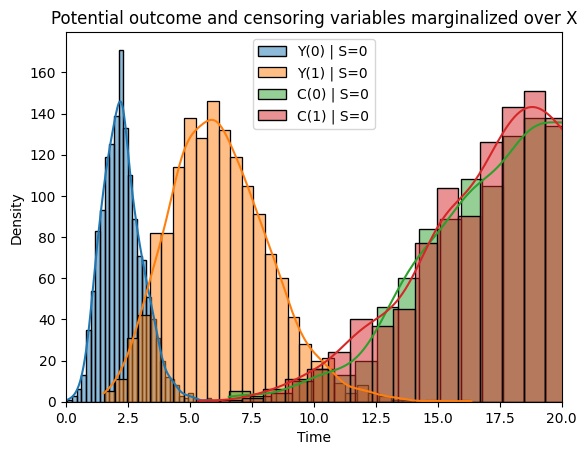

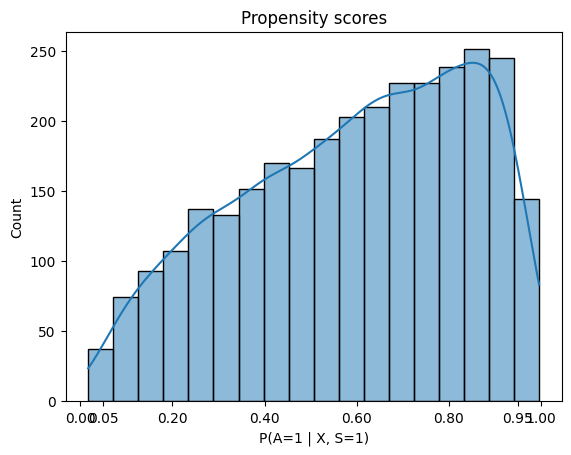

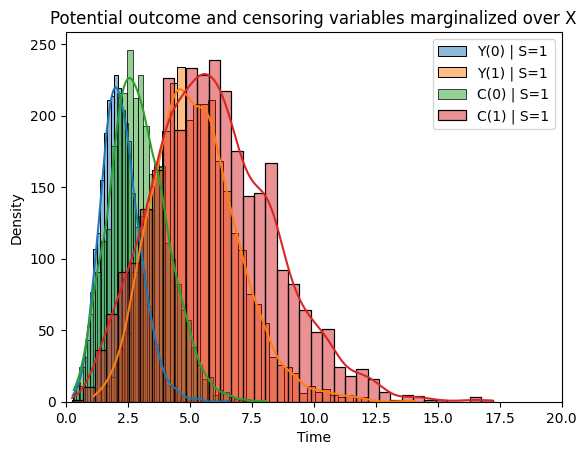

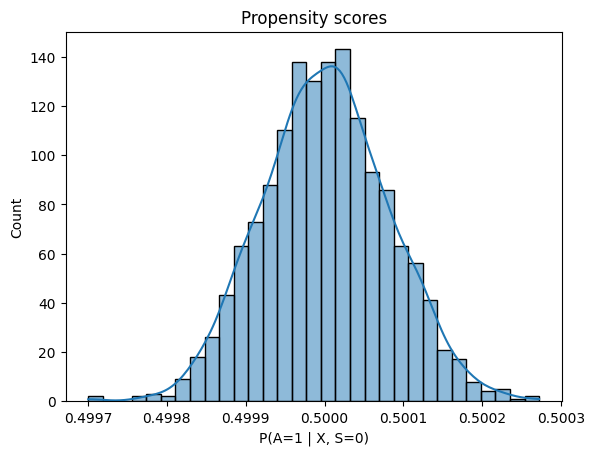

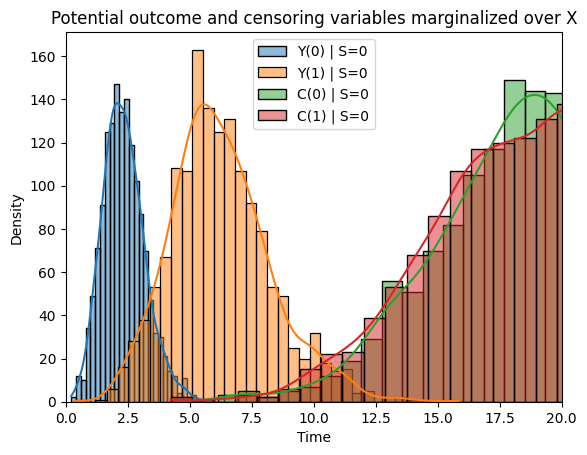

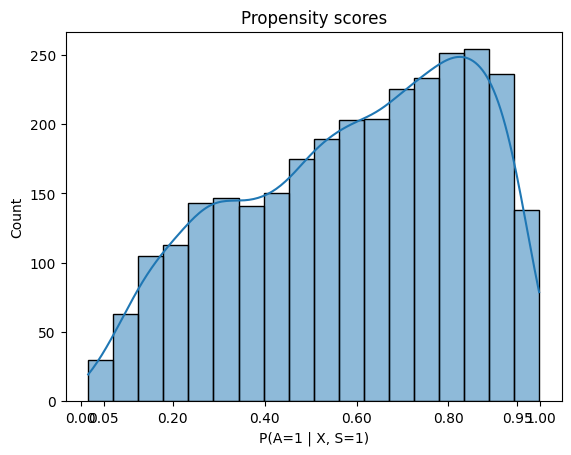

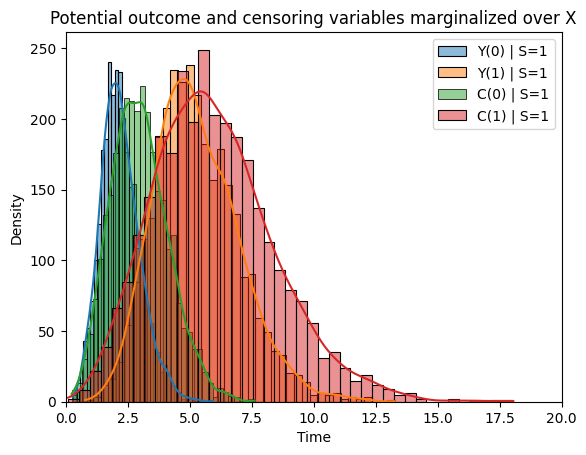

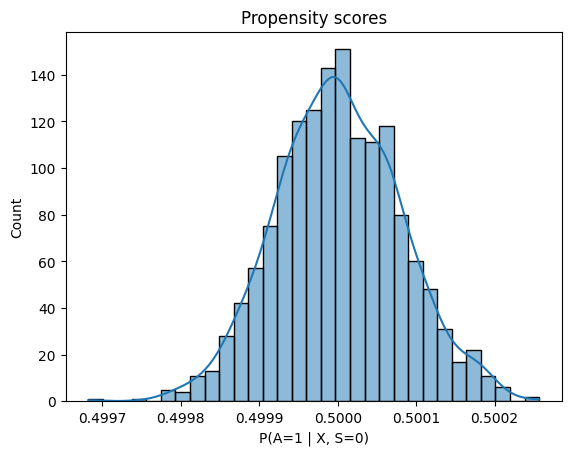

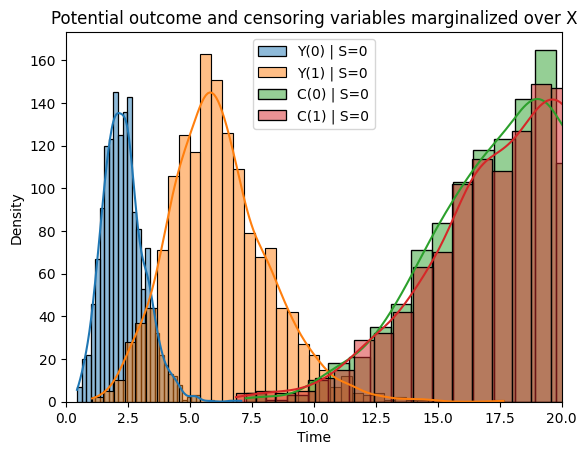

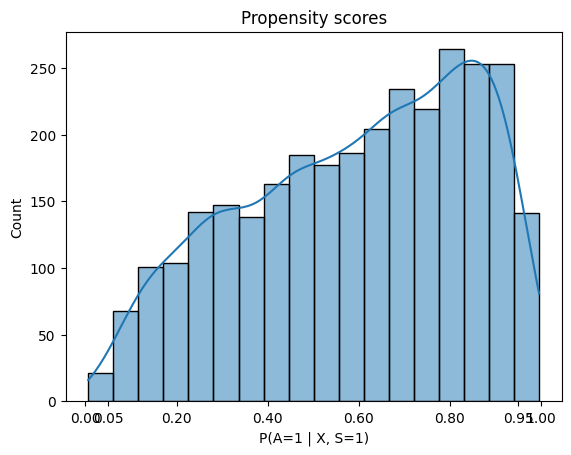

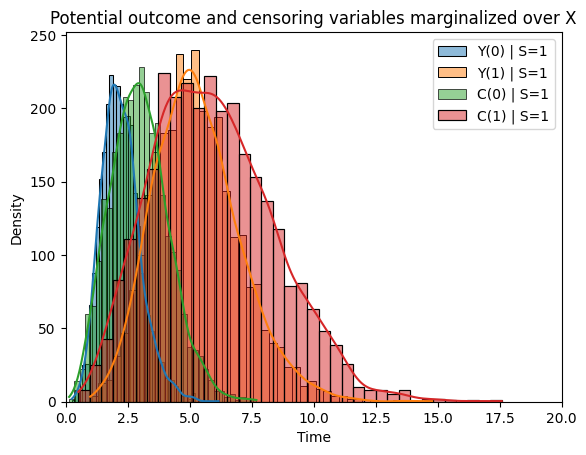

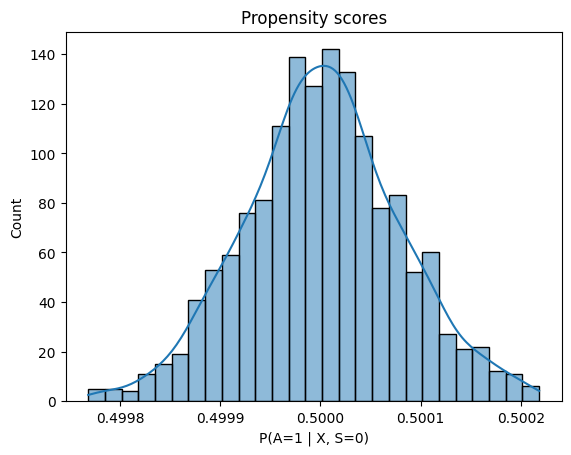

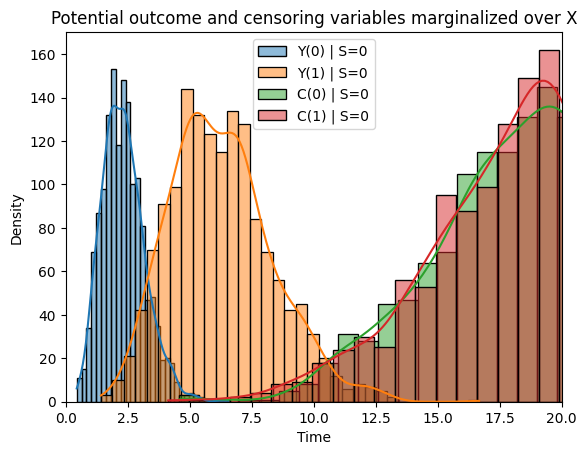

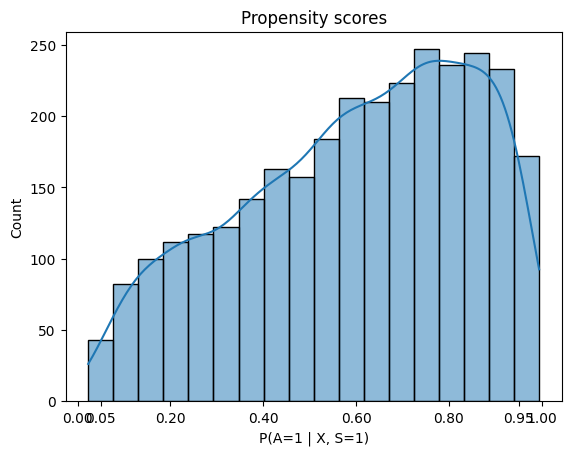

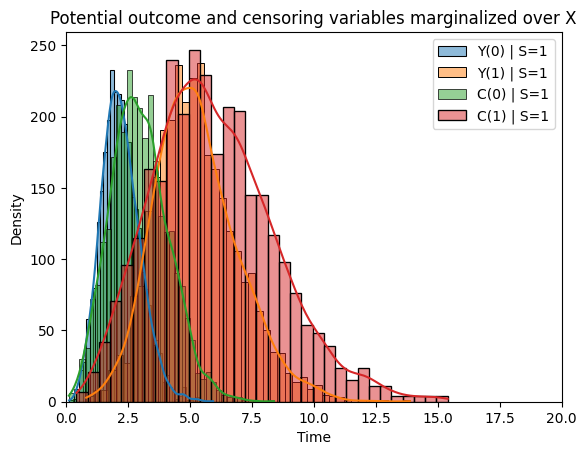

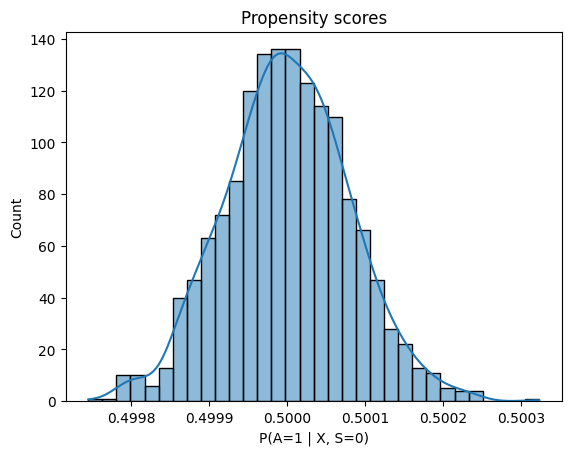

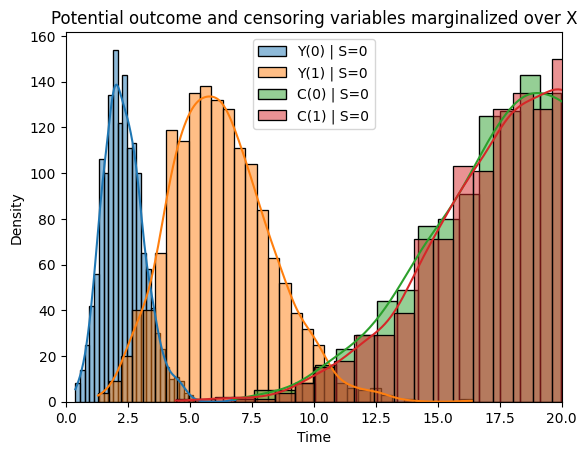

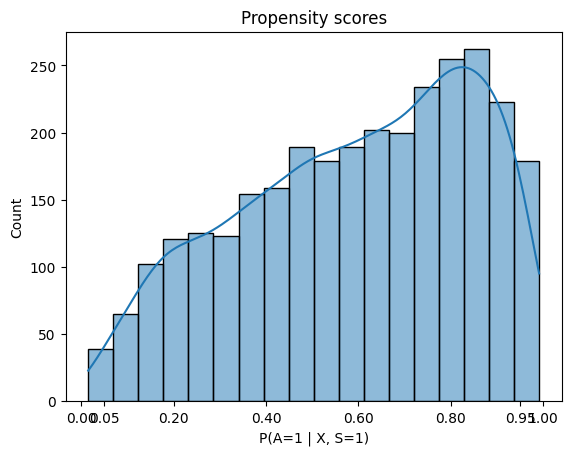

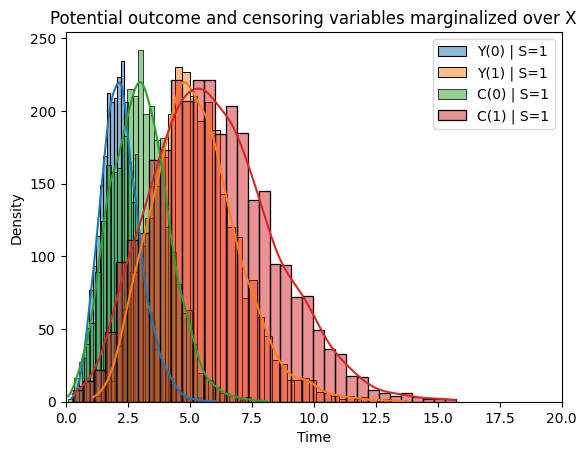

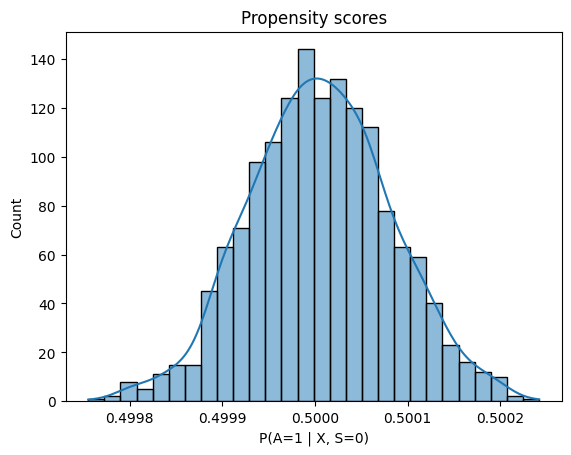

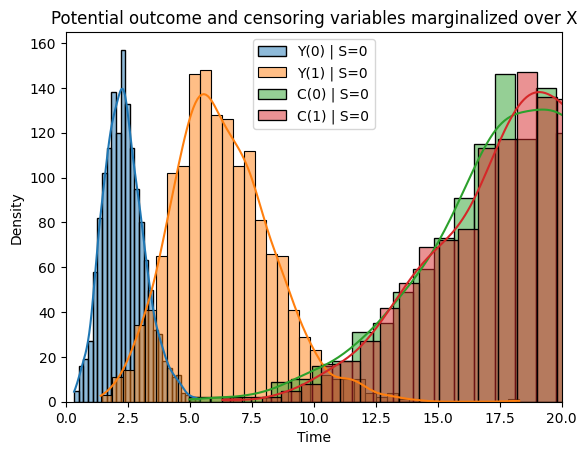

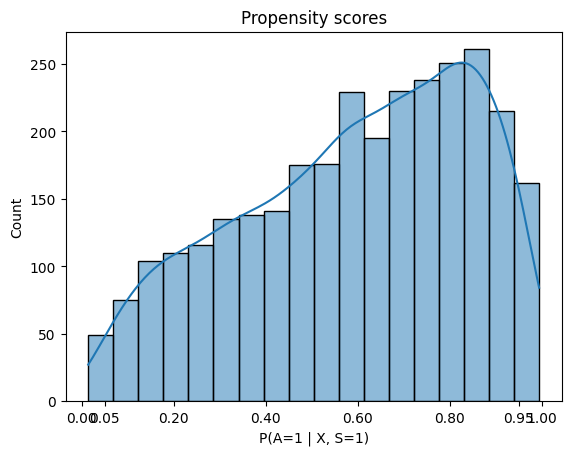

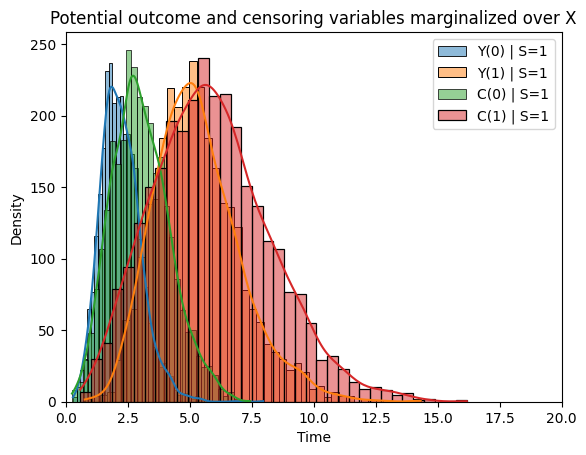

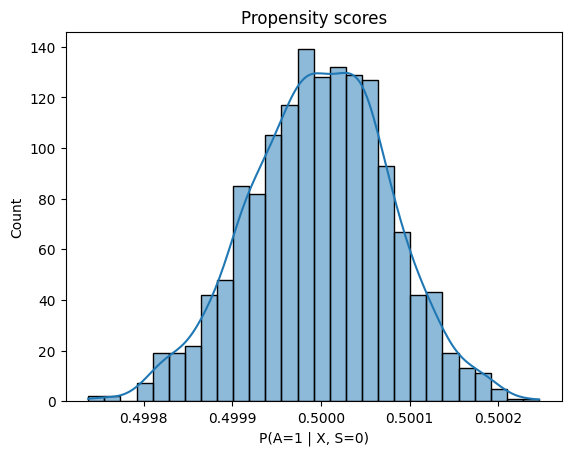

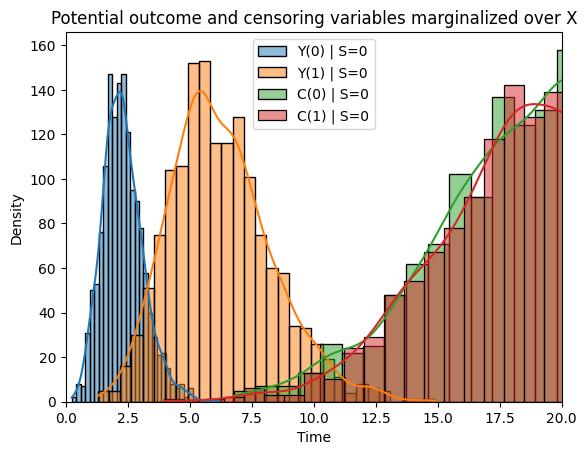

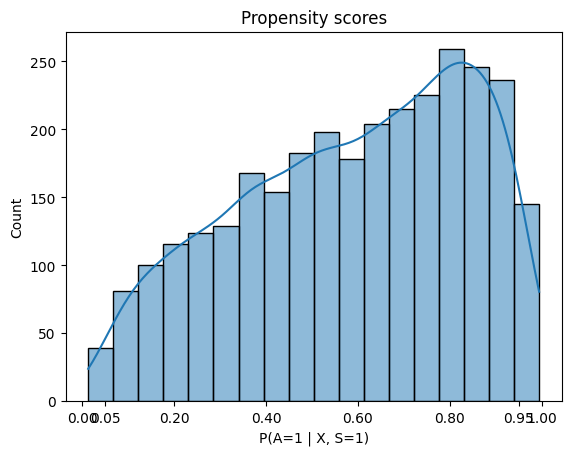

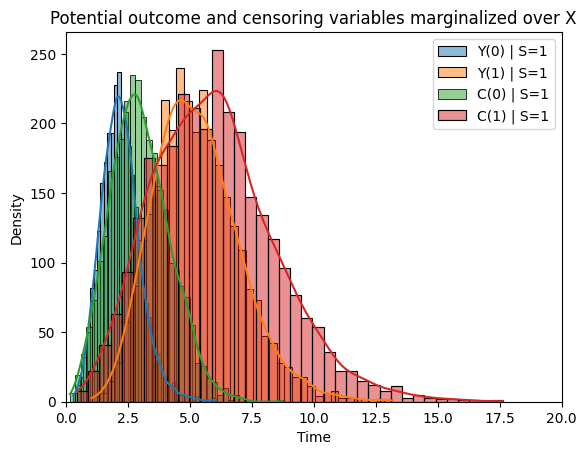

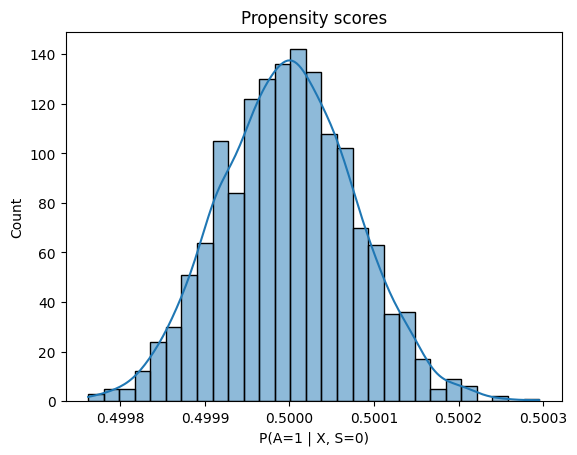

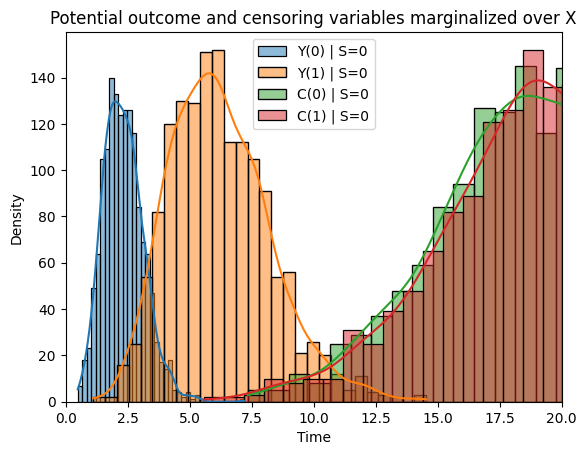

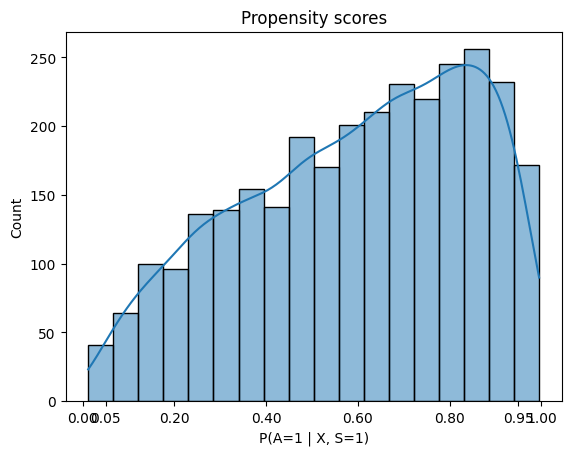

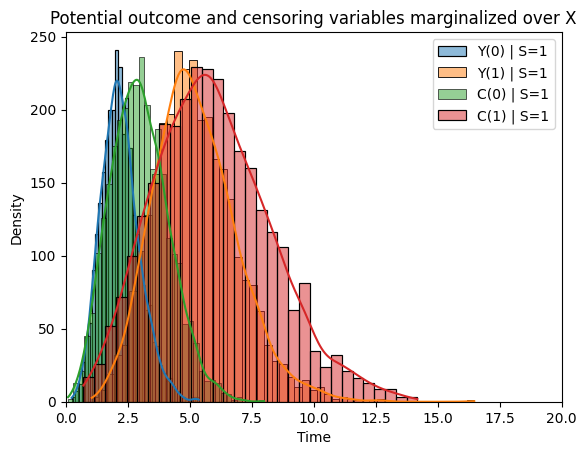

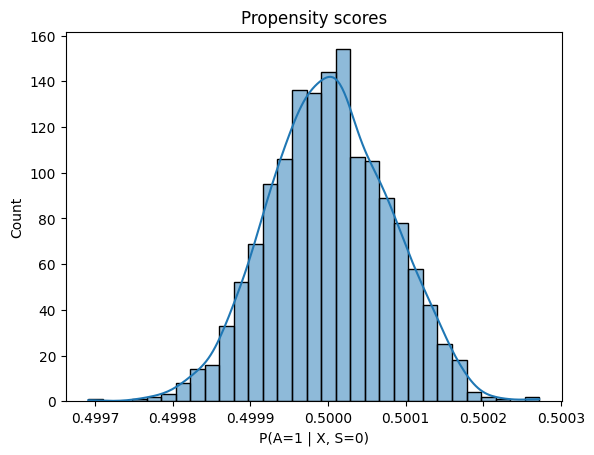

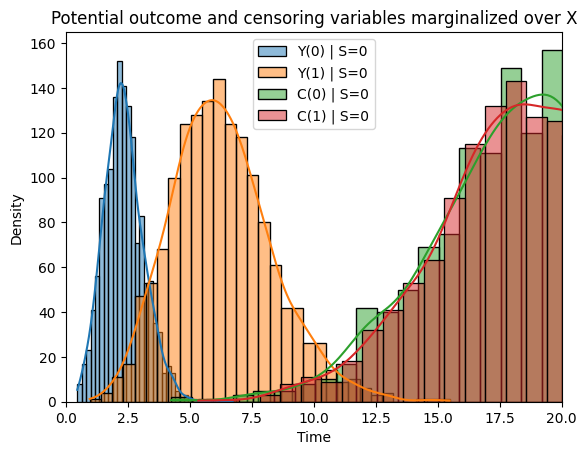

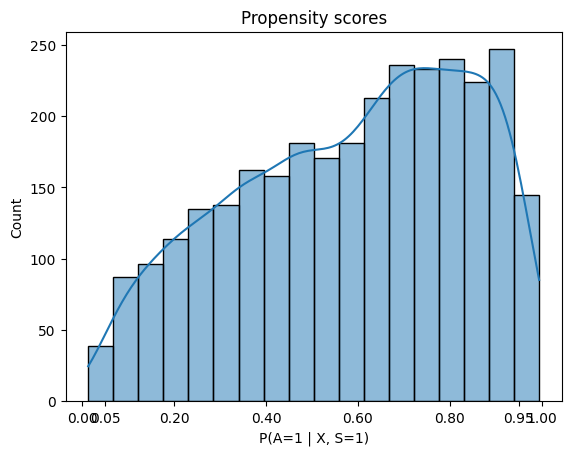

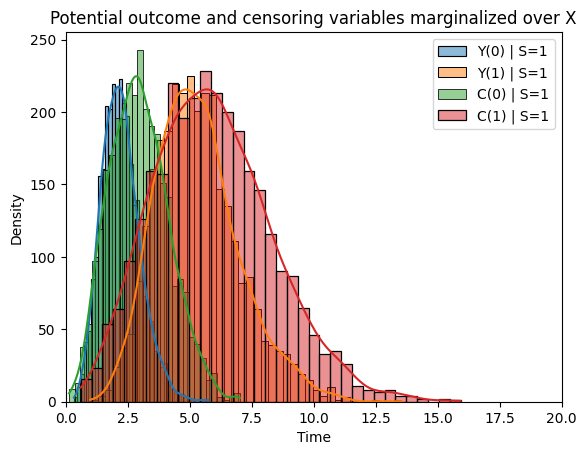

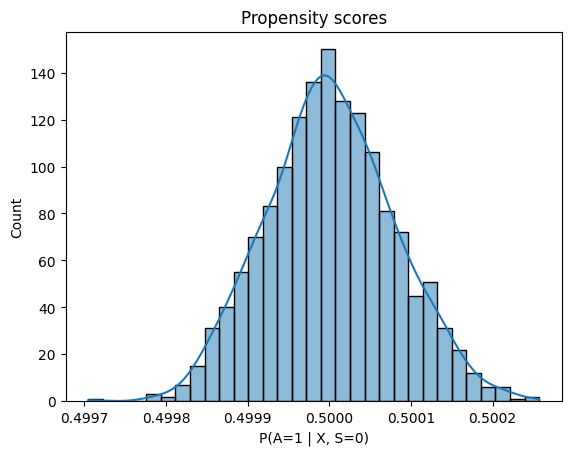

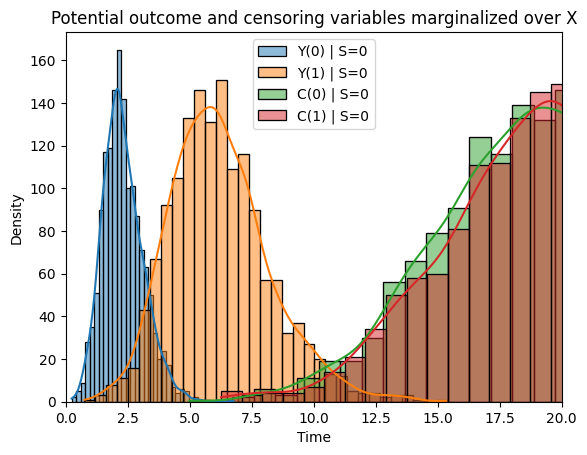

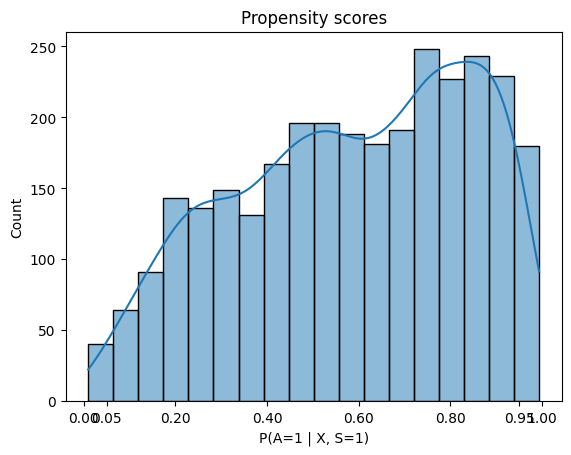

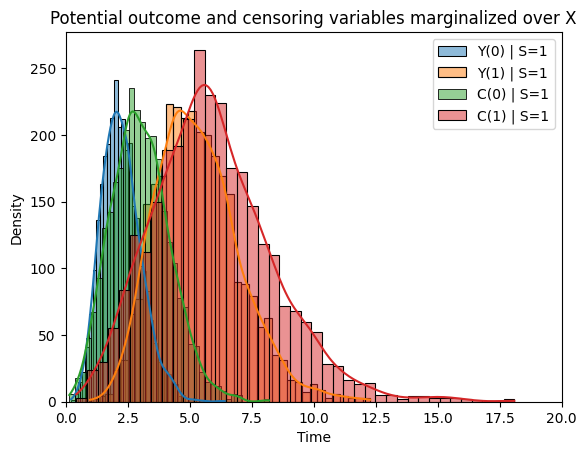

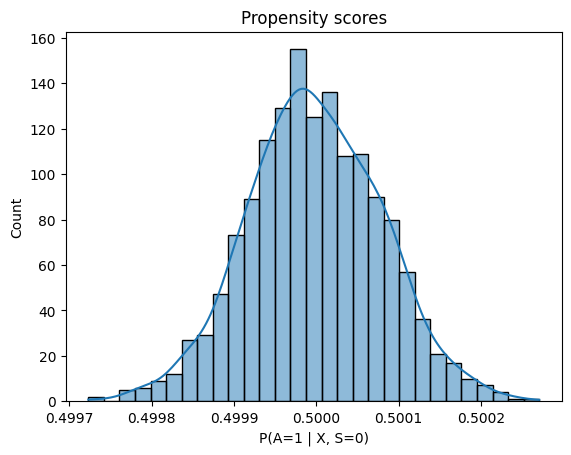

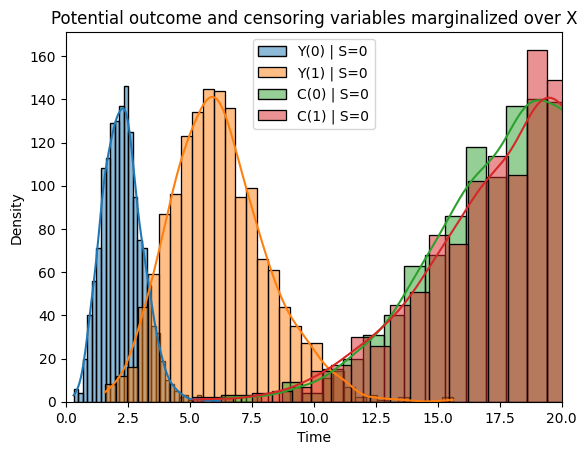

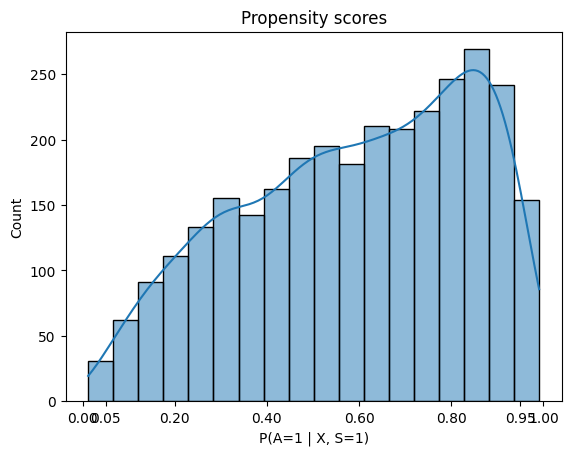

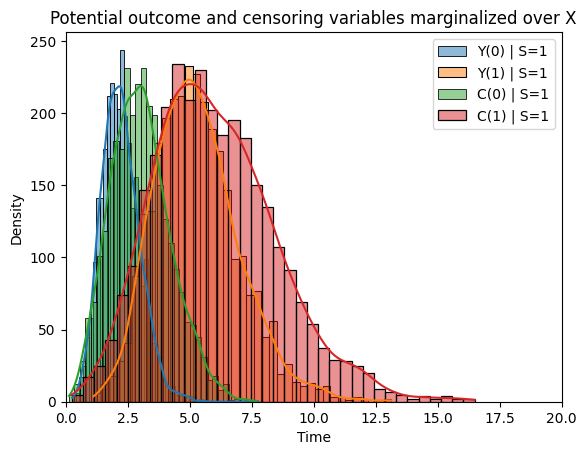

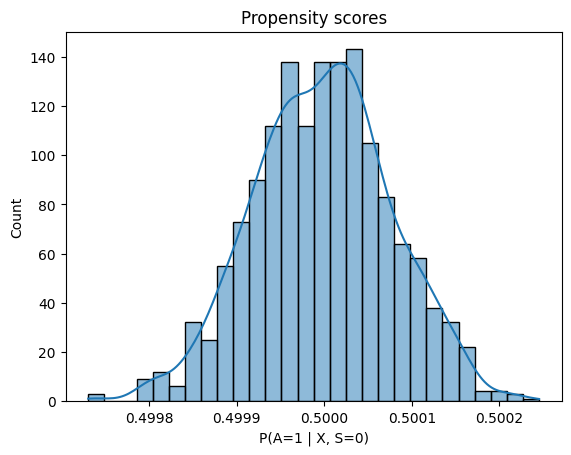

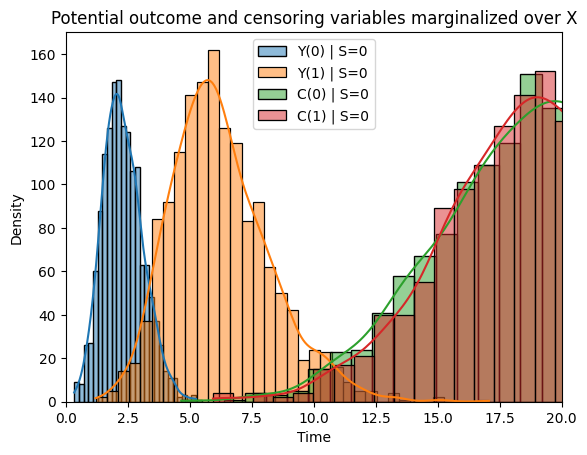

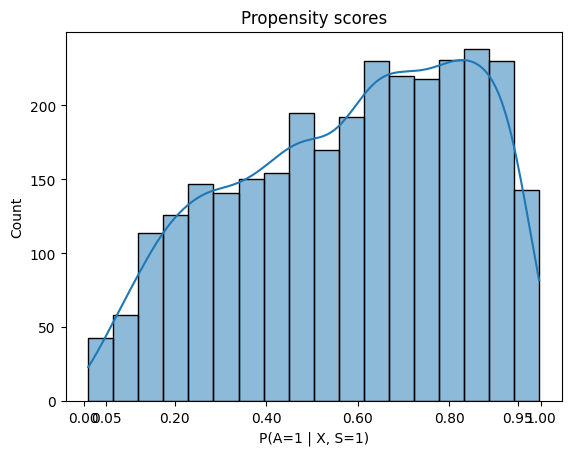

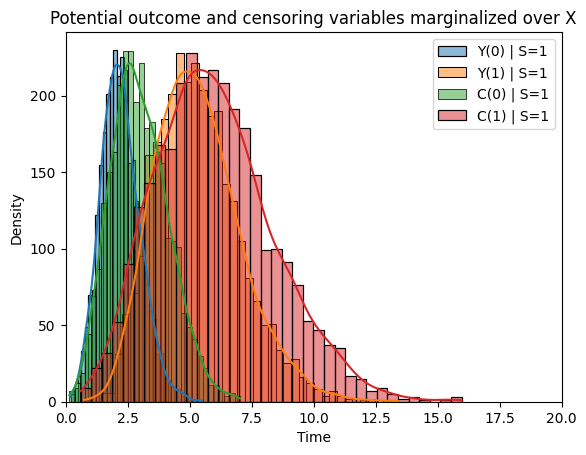

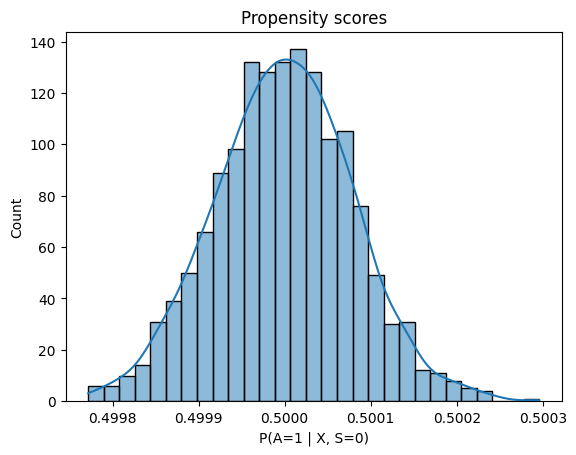

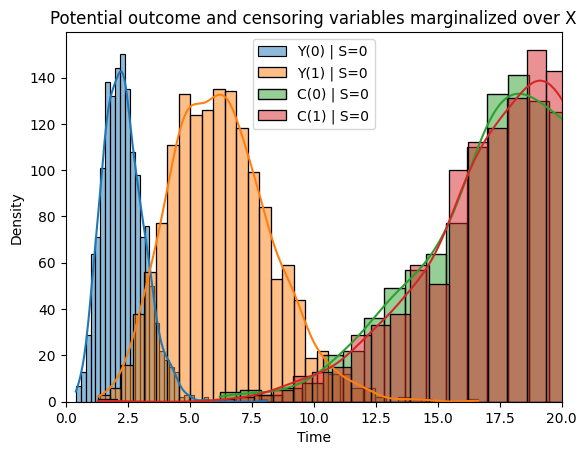

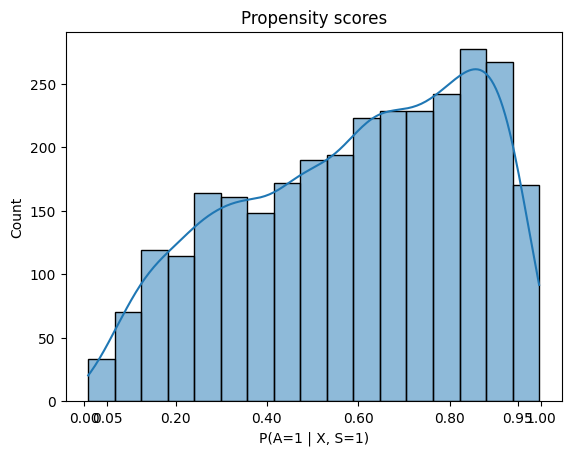

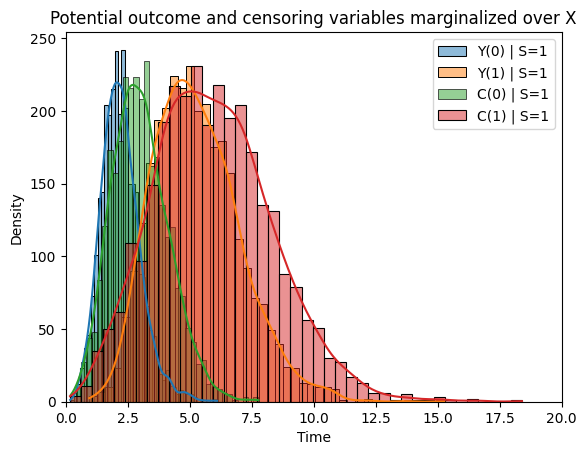

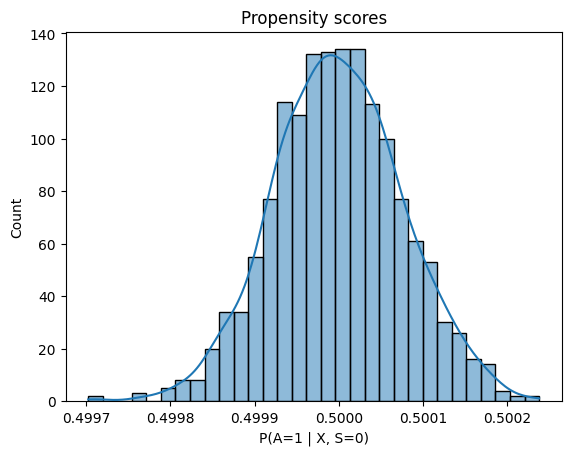

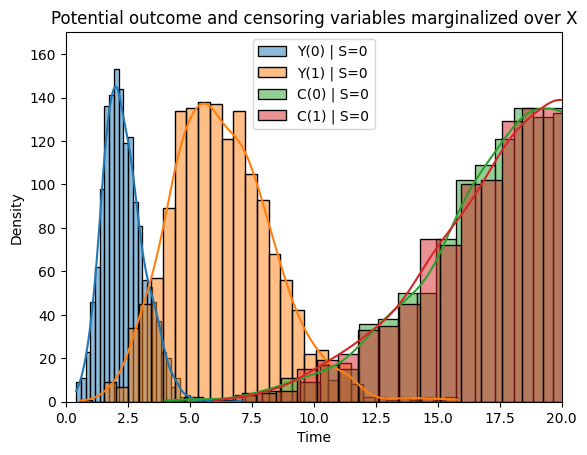

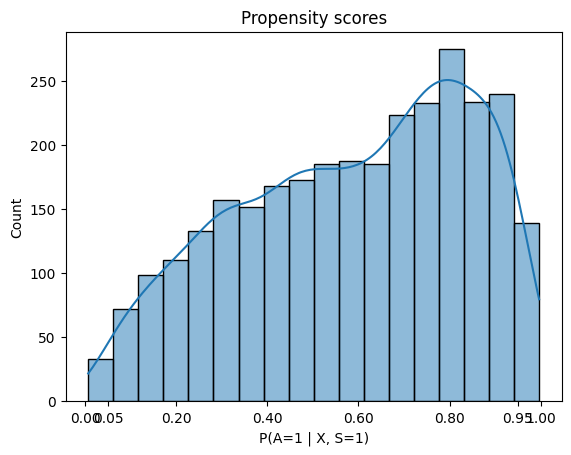

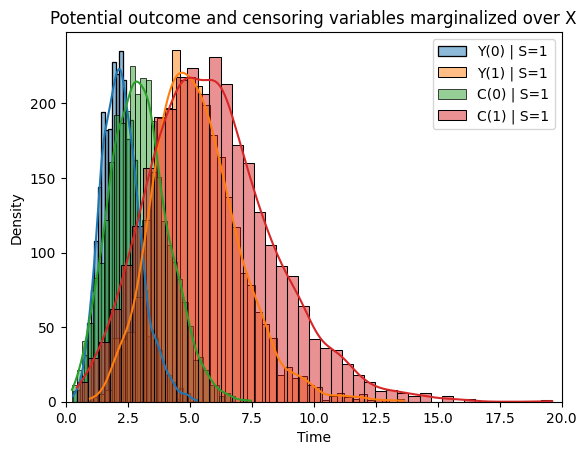

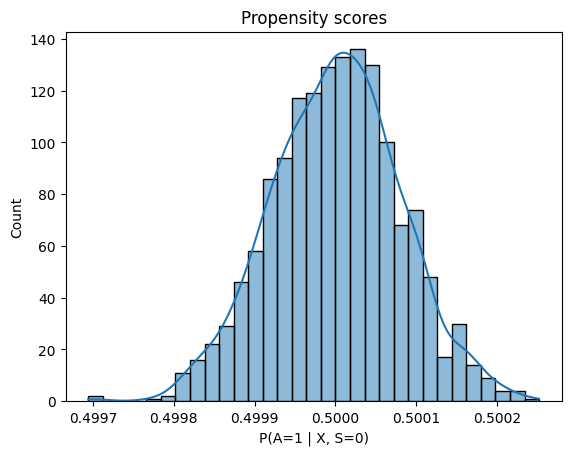

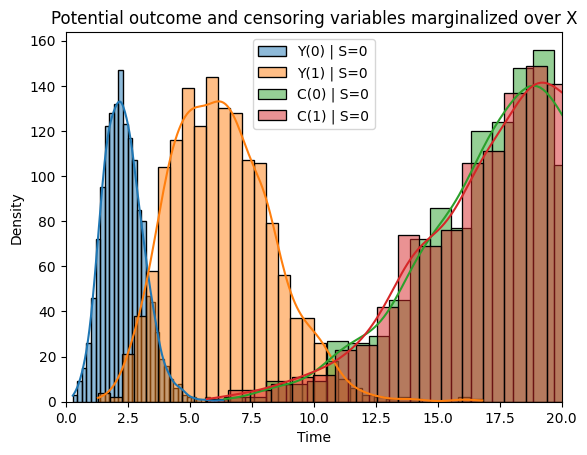

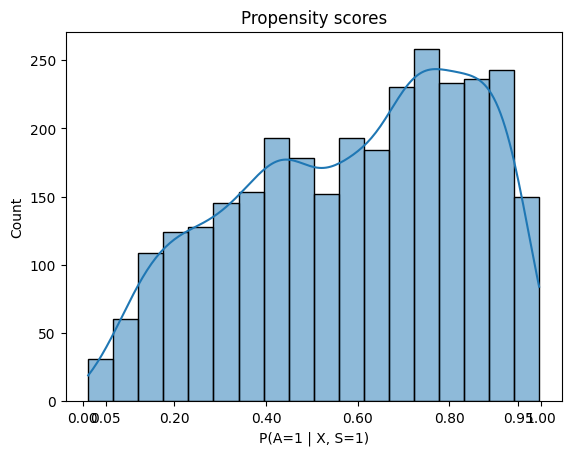

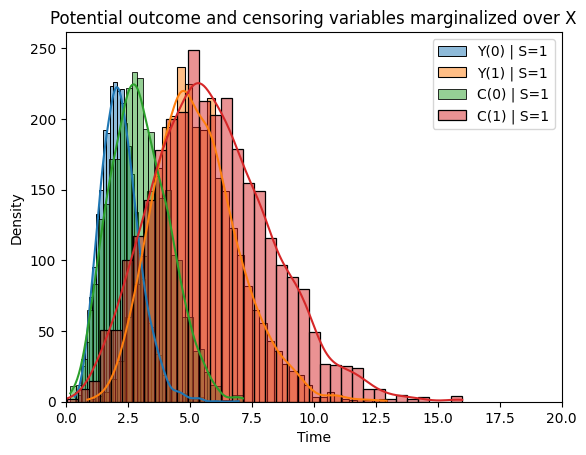

In [98]:
CD = 10
UC = 0
jD = read_json('complete-IC/samePO.json', CD, UC, ["IPCW"])
m = 2
os_size = jD['rct_size'] * m

pvals1 = np.zeros(20)
pvals2 = np.zeros(20)

for pind in range(20):

    t1 = time()

    df_combined, df_comb_drop, RCTData, OSData = generate_data(CD, os_size, jD)
    fill_nuisance(df_combined, df_comb_drop, jD)

    print('RCT size: {}, OS size: {}, time elapsed: {:.2f}'.format(jD['rct_size'], os_size, time() - t1))

    summary_df = pd.concat([RCTData.summary(plot=True), OSData.summary(plot=True)], axis=0, ignore_index=True)
    summary_df

    mmr_keys = ["IPCW"]
    crop_prop = True

    mmr_stats = np.zeros((len(mmr_keys), 2))  # store results and p-val for each mmr test

    for kind, key in enumerate(mmr_keys):
        if 'Drop' in key:
            df_mmr = df_comb_drop.copy()
        else:
            df_mmr = df_combined.copy()

        if jD['crop_prop'] and ('Drop' not in key):
            df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                    (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95) &\
                    (0.01 < df_mmr['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

        if jD['crop_prop'] and ('Drop' in key):
            df_mmr = df_mmr[(0.05 < df_mmr['P(S=1|X)']) & (df_mmr['P(S=1|X)'] < 0.95) &\
                    (0.05 < df_mmr['P(A=1|X,S)']) & (df_mmr['P(A=1|X,S)'] < 0.95)].copy().reset_index(drop=True)

        signal0, signal1 = jD['test_signals'][key][0], jD['test_signals'][key][1]
        mmr_stats[kind, 0], mmr_stats[kind, 1] = mmr_test(df_mmr, jD['cov_list'], jD['B'], laplacian_kernel, signal0, signal1)
        
        pvals1[pind] = mmr_stats[0][1]

In [90]:
mmr_stats[0]

array([0.        , 0.38613861])

In [99]:
np.mean(pvals1)

array([0.10891089, 0.42574257, 0.53465347, 0.71287129, 0.01980198,
       0.0990099 , 0.59405941, 0.96039604, 0.22772277, 0.44554455,
       0.00990099, 0.0990099 , 0.76237624, 0.22772277, 0.43564356,
       0.45544554, 0.33663366, 0.30693069, 0.07920792, 0.31683168])

In [97]:
np.mean(pvals2

array([0.15841584, 0.22772277, 0.31683168, 0.3960396 , 0.37623762,
       0.24752475, 0.22772277, 0.07920792, 0.16831683, 0.36633663,
       0.43564356, 0.3960396 , 0.14851485, 0.34653465, 0.31683168,
       0.15841584, 0.73267327, 0.34653465, 0.6039604 , 0.37623762])

In [50]:
len(df_mmr)

3000

In [41]:
df_mmr

X0        X1        X2        X3        X4        X5        X6  S  A  \
0     1.0  0.075538 -1.003012  0.338368 -0.011373  0.388152 -0.278164  0  0   
1     1.0  0.345248 -0.818060 -0.667172  0.810925 -0.300105 -0.417326  0  0   
2     1.0  0.207450  0.095263  0.868607  0.723124 -1.467739 -0.630715  0  1   
3     1.0 -0.739514  0.002842  0.045230  0.066279  0.157197 -0.138265  0  0   
4     1.0  0.512782  1.215122 -1.986450  1.862660  1.311398 -0.665357  0  1   
...   ...       ...       ...       ...       ...       ...       ... .. ..   
2994  1.0  2.712950 -1.575297 -0.513151 -1.029559 -1.242511 -0.487228  1  1   
2995  1.0  0.436691 -0.177163 -0.441313 -1.937204 -0.731909 -3.146340  1  0   
2996  1.0  0.615429  0.529549  0.733069 -3.076410  1.194389 -0.128177  1  0   
2997  1.0 -0.150493 -1.927260 -0.142314 -1.370755 -1.855957  0.999567  1  1   
2998  1.0 -1.036729  0.586686  1.708102 -0.779384 -0.033098 -0.604854  1  0   

              T  Delta  P(S=1|X)  P(A=1|X,S)  Gb(T|X,S,A)  S0_cdr_est_CATE  \
0      3.261016      1  0.495595    0.501212     1.000000        11.119288   
1      1.827193      1  0.459468    0.517050     1.000000         7.006929   
2      4.611906      1  0.621613    0.498138     1.000000         4.701709   
3      3.281047      1  0.374820    0.527512     1.000000        10.119891   
4     11.831493      1  0.203699    0.549161     1.000000        16.193581   
...         ...    ...       ...         ...          ...              ...   
2994   2.986300      0  0.765867    0.741551     0.899944         0.000000   
2995   1.211952      1  0.420261    0.306161     0.953890         0.000000   
2996   1.822470      1  0.490562    0.324180     0.850590         0.000000   
2997   6.382135      1  0.652882    0.628028     0.390214         0.000000   
2998   1.073662      0  0.476497    0.415813     0.960488         0.000000   

      S1_cdr_est_CATE  
0            0.000000  
1            0.000000  
2            0.000000  
3            0.000000  
4            0.000000  
...               ...  
2994         3.231978  
2995         5.033898  
2996         1.836327  
2997         9.263567  
2998         4.702691  

[2999 rows x 16 columns]

In [ ]:
len(df_mmr)

In [54]:
df_mmr['P(S=1|X)'].sort_values()

263     0.455619
345     0.487791
486     0.522515
24      0.571011
27      0.579189
          ...   
1661    0.949922
3036    0.949956
587     0.949956
2312    0.949959
1911    0.949996
Name: P(S=1|X), Length: 4049, dtype: float64

In [188]:
# print('CDR-S0-ATE: {:.2f}\n'.format(df_mmr['S0_cdr_est_CATE'].mean()))
# print('CDR-S1-ATE: {:.2f}\n'.format(df_mmr['S1_cdr_est_CATE'].mean()))

print('IPCW-S0-Y0: {:.2f}'.format(df_mmr['S0_ipcw_est_Y0'].mean()))
print('IPCW-S0-Y1: {:.2f}'.format(df_mmr['S0_ipcw_est_Y1'].mean()))
print('IPCW-S0-ATE: {:.2f}\n'.format(df_mmr['S0_ipcw_est_CATE'].mean()))

print('IPCW-S1-Y0: {:.2f}'.format(df_mmr['S1_ipcw_est_Y0'].mean()))
print('IPCW-S1-Y1: {:.2f}'.format(df_mmr['S1_ipcw_est_Y1'].mean()))
print('IPCW-S1-ATE: {:.2f}\n'.format(df_mmr['S1_ipcw_est_CATE'].mean()))

print('IPW-Impute-S0-Y0: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S0-Y1: {:.2f}'.format(df_mmr['S0_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S0-ATE: {:.2f}\n'.format(df_mmr['S0_impute_ipw_est_CATE'].mean()))

print('IPW-Impute-S1-Y0: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y0'].mean()))
print('IPW-Impute-S1-Y1: {:.2f}'.format(df_mmr['S1_impute_ipw_est_Y1'].mean()))
print('IPW-Impute-S1-ATE: {:.2f}\n'.format(df_mmr['S1_impute_ipw_est_CATE'].mean()))

print('IPW-Drop-S0-Y0: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S0-Y1: {:.2f}'.format(df_comb_drop['S0_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S0-ATE: {:.2f}\n'.format(df_comb_drop['S0_drop_ipw_est_CATE'].mean()))

print('IPW-Drop-S1-Y0: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y0'].mean()))
print('IPW-Drop-S1-Y1: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_Y1'].mean()))
print('IPW-Drop-S1-ATE: {:.2f}'.format(df_comb_drop['S1_drop_ipw_est_CATE'].mean()))

summary_df

IPCW-S0-Y0: 1.82
IPCW-S0-Y1: 4.37
IPCW-S0-ATE: 2.55

IPCW-S1-Y0: 1.84
IPCW-S1-Y1: 3.77
IPCW-S1-ATE: 1.93

IPW-Impute-S0-Y0: 1.82
IPW-Impute-S0-Y1: 4.35
IPW-Impute-S0-ATE: 2.53

IPW-Impute-S1-Y0: 1.84
IPW-Impute-S1-Y1: 4.11
IPW-Impute-S1-ATE: 2.26

IPW-Drop-S0-Y0: 1.84
IPW-Drop-S0-Y1: 4.31
IPW-Drop-S0-ATE: 2.47

IPW-Drop-S1-Y0: 1.88
IPW-Drop-S1-Y1: 3.95
IPW-Drop-S1-ATE: 2.07


S  d     n  True mean Y0  Impute mean Y0  Drop mean Y0  \
0  0  6  1000      1.796507        1.803788      1.803788   
1  1  6  5000      1.865725        1.806996      1.806694   

   Oracle-IPCW mean Y0  True mean Y1  Impute mean Y1  Drop mean Y1  \
0             1.833444      4.612311        4.525213      4.505646   
1             1.802746      4.349219        3.939428      3.899846   

   Oracle-IPCW mean Y1  True ATE  Impute ATE  Drop ATE  Oracle-IPCW ATE  
0             4.472231  2.815804    2.721425  2.701858         2.638787  
1             4.606610  2.483494    2.132433  2.093152         2.803864

In [ ]:
df_mmr


In [ ]:
df_mmr = df_combined
len(df_mmr)

In [38]:
row = 1778

s = df_mmr.loc[row, 'S']
a = df_mmr.loc[row, 'A']
x = np.array(df_combined.loc[row, jD['cov_list']])
T = df_mmr.loc[row, 'T']
Delta = df_mmr.loc[row, 'Delta']

df_mmr.loc[row]

X0                   1.000000
X1                   0.105393
X2                   0.300629
X3                  -0.902640
X4                  -0.366680
X5                  -1.811188
X6                   0.752109
S                    1.000000
A                    1.000000
T                    8.730674
Delta                0.000000
P(S=1|X)             0.513866
P(A=1|X,S)           0.479587
Gb(T|X,S,A)          0.021342
S0_cdr_est_CATE      0.000000
S1_cdr_est_CATE    555.818983
Name: 1778, dtype: float64

In [ ]:
eval_surv_(Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}'], T)

In [ ]:
eval_int_term_(s, a, x, T, Gb_C, Fb_Y)

In [ ]:
eval_Ystar_(s, a, x, Delta, T, Gb_C, Fb_Y)

In [ ]:
eval_Qfunc_(s, a, x, T, Fb_Y, thresh=1e-6)

In [48]:
df_mmr['S1_cdr_est_CATE'].sort_values()

2450    -49.907893
2773    -32.563120
2605    -23.244877
1890    -10.159278
1953    -10.154206
           ...    
1607     97.525391
2165    146.795533
2990    147.256033
2408    149.931850
2529    200.287360
Name: S1_cdr_est_CATE, Length: 2999, dtype: float64

In [ ]:
df_combined['T']

In [ ]:
top_5_indices = 

# Remove the rows with those indices from the DataFrame
df_filtered = df_combined.drop(df_combined['T'].nlargest(5).index)

In [ ]:
df_filtered['T'].max()

In [ ]:
df_combined['T'].max()

In [ ]:
df_mmr['S1_cdr_est_CATE'].sort_values()

In [ ]:
df_mmr['S1_ipcw_est_CATE'].sort_values()

In [ ]:
len(df_mmr)

In [ ]:
df_new['S0_cdr_est_CATE'].sort_values()

In [ ]:
df_new[['S1_cdr_est_CATE', 'S1_ipcw_est_CATE']].sort_values(by='S1_cdr_est_CATE')

In [ ]:
p_thr = 0.05

df_new = df_combined[(p_thr < df_combined['P(S=1|X)']) & (df_combined['P(S=1|X)'] < 1 - p_thr) &\
            (p_thr < df_combined['P(A=1|X,S)']) & (df_combined['P(A=1|X,S)'] < 1 - p_thr) &\
            (p_thr < df_combined['Gb(T|X,S,A)'])].copy().reset_index(drop=True)

# df_new_drop = df_comb_drop[(p_thr < df_comb_drop['P(S=1|X)']) & (df_comb_drop['P(S=1|X)'] < 1 - p_thr) &\
#             (p_thr < df_comb_drop['P(A=1|X,S)']) & (df_comb_drop['P(A=1|X,S)'] < 1 - p_thr)].copy().reset_index(drop=True)

In [ ]:
len(df_new)

In [ ]:
df_combined.sort_values(by='P(S=1|X)')

In [ ]:
s, a = 1, 1
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = tc #
st_arr = stc  

t1 = time()
func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
result, error = quad(func, 0, t_arr.max() + 10, limit=5)

print(f"Time: {time()-t1:.2f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max() + 10, 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
s, a = 0, 1
x = np.zeros(CD + 1)
ty, sty = Fb_Y[f't_S{s}_A{a}'], Fb_Y[f'St_S{s}_A{a}']
tc, stc = Gb_C[f't_S{s}_A{a}'], Gb_C[f'St_S{s}_A{a}']

t_arr = ty #
st_arr = sty  


func = interp1d(t_arr, st_arr, kind='nearest', fill_value='extrapolate')
t1 = time()
result, error = quad(func, 0, t_arr.max(), limit=1)
print(f"Time: {time()-t1:.5f} s.")
print(f"Result of integration: {result}, error: {error}")

xnew = np.arange(0, t_arr.max(), 0.1)
ynew = func(xnew)   # use interpolation function returned by `interp1d`
plt.plot(t_arr, st_arr, 'o', xnew, ynew, '--')
plt.show()

In [ ]:
Trange = np.linspace(0,8,51)
q_arr_normal = [eval_Qfunc_(s, a, x, T, Fb_Y) for T in Trange]
q_arr_batch = eval_Qfunc_arr_(s, a, x, Trange, Fb_Y)
plt.figure()
plt.plot(Trange, q_arr_normal, label='q_normal')
plt.plot(Trange, q_arr_batch, label='q_batch')
plt.legend()
plt.show()

In [52]:
pv = np.load('results/complete-IC/samePO/CD-10/UC-0/pvals.npy')
csv = pd.read_csv('results/complete-IC/samePO/CD-10/UC-0/res_summary.csv')

In [24]:
pv[0]

array([[0.32673267, 0.28712871, 0.1980198 , 0.27722772, 0.11881188,
        0.15841584, 0.1980198 , 0.07920792, 0.03960396, 0.28712871,
        0.15841584, 0.06930693, 0.1980198 , 0.07920792, 0.07920792,
        0.33663366, 0.15841584, 0.0990099 , 0.18811881, 0.16831683,
        0.15841584, 0.13861386, 0.20792079, 0.10891089, 0.30693069,
        0.01980198, 0.01980198, 0.05940594, 0.11881188, 0.24752475,
        0.10891089, 0.23762376, 0.16831683, 0.05940594, 0.08910891,
        0.18811881, 0.08910891, 0.12871287, 0.37623762, 0.0990099 ],
       [0.03960396, 0.00990099, 0.01980198, 0.04950495, 0.02970297,
        0.04950495, 0.00990099, 0.01980198, 0.02970297, 0.02970297,
        0.00990099, 0.01980198, 0.01980198, 0.01980198, 0.03960396,
        0.04950495, 0.02970297, 0.01980198, 0.01980198, 0.00990099,
        0.02970297, 0.06930693, 0.00990099, 0.02970297, 0.01980198,
        0.03960396, 0.00990099, 0.01980198, 0.02970297, 0.02970297,
        0.03960396, 0.01980198, 0.01980198, 0.0

In [54]:
np.mean(pv[0], axis=1)

array([0.38118812, 0.54480198, 0.08267327, 0.18836634])

In [53]:
csv

Test  m = 1  m = 2
0        IPCW  0.200  0.100
1         CDR  0.150  0.100
2  IPW-Impute  0.725  0.850
3    IPW-Drop  0.450  0.675

In [29]:
a = [0,1,2,3]

In [30]:
a[:-1]

[0, 1, 2]

In [ ]:
x_space = np.linspace(-10,10,401)
cov_name = 'X1'
os_oracle_prop = OSData.calc_oracle_prop(x_space, cov_name)
plt.figure()
plt.plot(x_space, os_oracle_prop)
plt.xlabel(cov_name)
plt.ylabel(f'P(A=1|{cov_name},S=1)')
plt.title(f'Oracle propensity score in study S=1 wrt covariate {cov_name}')
plt.show()

t = np.linspace(0,20,101)
cov_vals = [0, 0, 0, 0]
tbs_Y0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y0')
tbs_Y1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'Y1')
tbs_C0 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C0')
tbs_C1 = RCTData.get_oracle_surv_curve(t, cov_vals, 'C1')
plt.figure()
plt.plot(t, tbs_Y0, label='Y0', alpha= 0.4, ls ='--')
plt.plot(t, tbs_Y1, label='Y1', alpha= 1, ls ='-.')
plt.plot(t, tbs_C0, label='C0', alpha= 0.4)
plt.plot(t, tbs_C1, label='C1', alpha= 0.4)
plt.xlabel('t')
plt.ylabel(r'$S(t)$')
plt.title(f'True survival curves in study S=0 with X={cov_vals}')
plt.legend()
plt.show()